In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Xopt class, TNK test function

This is the class method for running Xopt.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [2]:
# Import the class
from xopt import Xopt

The `Xopt` object can be instantiated from a JSON or YAML file, or a dict, with the proper structure.

Here we will make one

In [3]:
import yaml
# Make a proper input file. 
YAML="""
xopt: {output_path: null, verbose: true}

algorithm:
  name: bayesian_exploration
  options: {n_initial_samples: 5,
            use_gpu: False,
            restart_data_file: opt_data.json,
            n_steps: 20, 
            verbose: True}
  
simulation: 
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK  
  
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: None}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: ['LESS_THAN', 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

"""
config = yaml.safe_load(YAML)

In [4]:
# Optional: Connect the function directly
#from xopt.evaluators.test_TNK import evaluate_TNK 
#config['simulation']['evaluate'] = evaluate_TNK 

X = Xopt(config)
X

Loading config as dict.



            Xopt 
________________________________           
Version: 0.4.3
Configured: True
Config as YAML:
xopt: {output_path: null, verbose: true}
algorithm:
  name: bayesian_exploration
  function: xopt.bayesian_exploration.bayesian_exploration
  options: {n_initial_samples: 5, use_gpu: false, restart_data_file: 'C:\Users\Ryan
      Roussel\Documents\GitHub\xopt\examples\bayes_exp\opt_data.json', n_steps: 20,
    verbose: true}
simulation:
  name: test_TNK
  evaluate: xopt.evaluators.test_TNK.evaluate_TNK
  options: {extra_option: abc}
vocs:
  name: TNK_test
  description: null
  simulation: test_TNK
  templates: null
  variables:
    x1: [0, 3.14159]
    x2: [0, 3.14159]
  objectives: {y1: None}
  constraints:
    c1: [GREATER_THAN, 0]
    c2: [LESS_THAN, 0.5]
  linked_variables: {x9: x1}
  constants: {a: dummy_constant}

In [5]:
# Note that the repr string contains all of the config information
X.random_evaluate()

{'y1': 0.5969391388717775,
 'y2': 2.6361117867569437,
 'c1': 6.3966707349049985,
 'c2': 4.572370762167144,
 'some_array': array([1, 2, 3])}

# Run CNSGA

CNSGA is designed to run in parallel with an asynchronous executor as defined in PEP 3148

In [6]:
# Pick one of these
from concurrent.futures import ThreadPoolExecutor as PoolExecutor
#from concurrent.futures import ProcessPoolExecutor as PoolExecutor

executor = PoolExecutor()
# This will also work. 
#executor=None

In [7]:
# Change max generations
X.run(executor=executor)

Starting at time 2021-08-05T15:40:42-05:00
tensor([[0.0730, 1.0480]], dtype=torch.float64)
tensor([[0.4476, 0.9536]], dtype=torch.float64)
tensor([[0., 0.]], dtype=torch.float64)
tensor([[1.0516, 0.0798]], dtype=torch.float64)
tensor([[1.1902, 0.5480]], dtype=torch.float64)
tensor([[0.5835, 0.8279]], dtype=torch.float64)
tensor([[0.9679, 1.0085]], dtype=torch.float64)
tensor([[0.8815, 0.4928]], dtype=torch.float64)
tensor([[0.5928, 1.1866]], dtype=torch.float64)
tensor([[0.5661, 0.7996]], dtype=torch.float64)
tensor([[1.0420, 0.0650]], dtype=torch.float64)
tensor([[0.2898, 1.1576]], dtype=torch.float64)
tensor([[1.1449, 0.7550]], dtype=torch.float64)
tensor([[0.2616, 1.0042]], dtype=torch.float64)
tensor([[1.1787, 0.3514]], dtype=torch.float64)
tensor([[0.2565, 0.9634]], dtype=torch.float64)
tensor([[0.0625, 1.0417]], dtype=torch.float64)
tensor([[0.8759, 0.4783]], dtype=torch.float64)
tensor([[0.8710, 1.0873]], dtype=torch.float64)
tensor([[0.4857, 1.1951]], dtype=torch.float64)


# Plot

tensor([[2.9214, 1.8261],
        [2.7454, 2.0206],
        [0.1240, 2.9701],
        [0.6984, 1.0525],
        [0.5987, 0.1152],
        [0.0000, 0.6866],
        [1.2437, 0.4494],
        [0.9667, 0.8179],
        [0.4193, 1.0537],
        [1.1114, 0.2730],
        [0.7844, 0.8239],
        [0.9674, 0.0669],
        [0.2792, 1.1071],
        [0.8768, 1.0475],
        [0.1429, 1.0756],
        [1.1035, 0.7980],
        [0.9737, 0.5174],
        [0.0796, 1.0464],
        [0.5853, 1.1669],
        [1.0707, 0.1146],
        [0.6005, 0.9138],
        [1.0902, 0.8550],
        [0.7887, 1.1251],
        [0.9304, 0.5161],
        [0.4449, 1.1842],
        [0.0730, 1.0480],
        [0.4476, 0.9536],
        [0.0000, 0.0000],
        [1.0516, 0.0798],
        [1.1902, 0.5480],
        [0.5835, 0.8279],
        [0.9679, 1.0085],
        [0.8815, 0.4928],
        [0.5928, 1.1866],
        [0.5661, 0.7996],
        [1.0420, 0.0650],
        [0.2898, 1.1576],
        [1.1449, 0.7550],
        [0.2

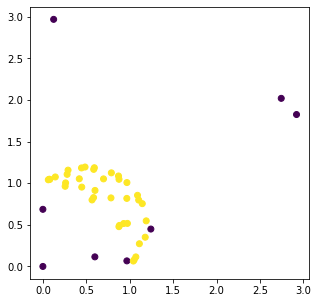

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

train_x = X.results['inputs']
print(train_x)
feas = X.results['feasibility']
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(*train_x.T, c = feas.int())
